# Step 2: Combine staffing levels

THIS FILE IS MODIFIED to clean up village names.

This file combines all staffing level files in the EDSIGHT_STAFFING folder, and generates two files, described below:

### output/2_staffing.csv

This file contains aggregate annual staffing totals by district and year. It includes only public school districts, and it contains a column denoting whether that year contained any null values -- meaning categories of employees where no numeric value was provided. This appears to represent legitimate zero values for many rows, but it also appears to indicate missing data in some cases. The reason we need this "asterisk" is that in cases where data is missing, it would falsely be identified later on as a cut or increase.


### output/byproduct_2_all_staffing.csv

This file is not aggregated, and is not limited to public school districts. It is NOT used in the workflow, and therefore not prefixed with a number. It is only saved as output because it seems like a pretty useful thing to have.



### ./data files

Here's what's in the data folder

In [1]:
ls "data/EDSIGHT_STAFFING/"

FTEStaffing (1).csv   FTEStaffing (15).csv  FTEStaffing (6).csv
FTEStaffing (10).csv  FTEStaffing (16).csv  FTEStaffing (7).csv
FTEStaffing (11).csv  FTEStaffing (2).csv   FTEStaffing (8).csv
FTEStaffing (12).csv  FTEStaffing (3).csv   FTEStaffing (9).csv
FTEStaffing (13).csv  FTEStaffing (4).csv   FTEStaffing.csv
FTEStaffing (14).csv  FTEStaffing (5).csv


In [2]:
import pandas as pd

In [3]:
class EdsightReport(object):
    
    def fix_equals(self, col):
        self.df[col] = self.df[col].str.strip("=").str.strip("\"")
    
    def __init__(self, fname):
        self.fname = fname
        self.report_name = open(self.fname).readline().strip().strip("\"")
        self.df = pd.read_csv(self.fname,skiprows=2)

In [4]:
cleaner_csv = pd.read_csv("https://raw.githubusercontent.com/jakekara/ctnamecleaner-py/master/ctlookup/data/ctnamecleaner.csv").set_index("name")
#print cleaner_csv.loc["NORTH FRANKLIN"]

def clean_town_name(tname):
    
    # Not in the cleaner CSV. I should add this
    if tname == "North Grosvenor": return "THOMPSON"
    
    try:
        matches = cleaner_csv.loc[tname.upper().strip()]
    
    
        if len(matches) == 1:
            return str(matches["real.town.name"])

    except: pass
    
    return tname

clean_town_name("NORTH Franklin")

'FRANKLIN'

In [5]:
class SchoolOrganizations(EdsightReport):
    
    def __init__(self, *args, **kwargs):
        super(SchoolOrganizations, self).__init__("data/findSchoolDistrict.csv", *args, **kwargs)
        self.fix_equals("OrganizationCode")
        self.fix_equals("ZIP")
        for grade_column in ["Grade " + str(x) for x in range(1, 13)]:
            self.fix_equals(grade_column)
            
class Districts(SchoolOrganizations):
    
    def find_by_city(self, city):
        return self.df[self.df["City"].str.upper().str.strip().str.contains(city.upper().strip())][["OrganizationName","OrganizationType"]]
    
    def find_by_name(self, name):
        return self.df[self.df["OrganizationName"].str.upper() == name.upper()]
    
    def __init__(self, *args, **kwargs):
        super(Districts, self).__init__()
        self.df = self.df[self.df["OrganizationType"].str.contains("District")]
        
    
districts = Districts()
print districts.report_name
districts.df["OrganizationType"].value_counts()
print districts.find_by_city("Bridgeport")

Find School/District Results
                                     OrganizationName  \
719                        Bridgeport School District   
807   Capital Preparatory Harbor School Inc. District   
1135               Great Oaks Charter School District   
1493       New Beginnings Inc Family Academy District   
1730           Park City Prep Charter School District   
2057                      The Bridge Academy District   

                     OrganizationType  
719           Public School Districts  
807   Public Charter School Districts  
1135  Public Charter School Districts  
1493  Public Charter School Districts  
1730  Public Charter School Districts  
2057  Public Charter School Districts  


In [6]:
# Districts that wouldn't resolve
fix_list = ['CANTON', 'EAST HADDAM', 'FRANKLIN', 'GROTON', 'HARTLAND',
           'KILLINGLY', 'MONTVILLE', 'NORTH BRANFORD', 'PLYMOUTH', 'POMFRET',
           'SPRAGUE', 'STAFFORD', 'STONINGTON', 'THOMPSON', 'WINCHESTER',
           'WINDHAM']

In [7]:
districts.df[districts.df["City"].str.contains("Franklin")]

,OrganizationType,District,OrganizationCode,OrganizationName,Street,City,State,ZIP,Phone,Fax,...,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12
1114,Public School Districts,Franklin School District,0530011,Franklin School District,206 Pond Road,North Franklin,CT,06254,860-642-6113,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
districts.df["CityClean"] = districts.df["City"].apply(clean_town_name)


In [9]:
for d in districts.df[districts.df["City"].str.upper() != districts.df["CityClean"]]["CityClean"].unique():
    print d, d in fix_list

CANAAN False
CANTON True
EAST HADDAM True
WINCHESTER True
FRANKLIN True
STONINGTON True
HARTLAND True
KILLINGLY True
MANSFIELD False
MONTVILLE True
NORTH BRANFORD True
PLYMOUTH True
POMFRET True
WASHINGTON False
HADDAM False
SALISBURY False
SPRAGUE True
STAFFORD True
THOMPSON True
WINDHAM True


In [10]:

# Manually force it for Groton schools, which are in Mystic
def force_groton(row):
    #print row["OrganizationName"] == "Groton School District"
    if row["OrganizationName"] == "Groton School District": 
        return "GROTON"
    return str(row["CityClean"])
districts.df["CityClean2"] = districts.df.apply(force_groton,axis=1)
districts.df[districts.df["CityClean"] != districts.df["CityClean2"]]

,OrganizationType,District,OrganizationCode,OrganizationName,Street,City,State,ZIP,Phone,Fax,...,Grade 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,CityClean,CityClean2
1165,Public School Districts,Groton School District,0590011,Groton School District,1300 Flanders Road,Mystic,CT,06355,860-572-2100,860-572-5822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STONINGTON,GROTON


In [11]:
# OK the fix worked. Using CityClean for City
districts.df["City"] = districts.df["CityClean2"]

In [12]:
class StaffingReport(EdsightReport):
    
    def __init__(self, *args, **kwargs):
        super(StaffingReport, self).__init__(*args, **kwargs)
        self.year = self.report_name.replace("FTE Staffing Report for ", "")
        self.fiscal_year = self.year[:2] + self.year[-2:]
        self.df["District"] = self.df["District"].fillna(method="ffill")
        self.fix_equals("District")
        self.fix_equals("Assignment Category")
        self.fix_equals("Educator Type")
        self.df = self.df.set_index(["District","Assignment Category","Educator Type"])
        self.df["report_year"] = self.fiscal_year
        self.df = self.df.reset_index().set_index("District").join(districts.df.set_index("OrganizationName")[["City","OrganizationCode","OrganizationType"]])

er = StaffingReport("data/EDSIGHT_STAFFING/FTEStaffing (1).csv")
print er.report_name
print er.year
print er.fiscal_year
er.df.head()


FTE Staffing Report for 2002-03
2002-03
2003


,Assignment Category,Educator Type,FTE Count,report_year,City,OrganizationCode,OrganizationType
Amistad Academy District,Administrators Coordinators and Department Ch...,Certified,1.8,2003,NEW HAVEN,2790013,Public Charter School Districts
Amistad Academy District,Counselors Social Workers and School Psychol...,Certified,1.0,2003,NEW HAVEN,2790013,Public Charter School Districts
Amistad Academy District,General Education - Teachers and Instructors,Certified,14.9,2003,NEW HAVEN,2790013,Public Charter School Districts
Amistad Academy District,General Education - Paraprofessional Instructi...,Non-Certified,3.0,2003,NEW HAVEN,2790013,Public Charter School Districts
Amistad Academy District,Library/Media - Support Staff,Non-Certified,0.0,2003,NEW HAVEN,2790013,Public Charter School Districts


In [13]:
print "These are districts that can't be reconciled to a city"
set(er.df[er.df["City"].isnull()].index.tolist())

These are districts that can't be reconciled to a city


{'Highville Mustard Seed Charter School District',
 'Office of Early Childhood (OEC)',
 'Project Oceanology',
 'Unified School District #1',
 'Unified School District #2'}

In [14]:
# Now pull in all the school stuff
import os

def all_staffing_years(fdir="data/EDSIGHT_STAFFING/"):
    frames = []
    years = []

    for f in os.listdir(fdir):
        print f
        if not f.endswith(".csv"): continue
        fpath = os.path.join(fdir,f)
        report = StaffingReport(fpath)
        #print (report.fiscal_year)
        if int(report.fiscal_year) in years:
            raise Exception("Duplicate year: " + str(report.fiscal_year))
        years.append(int(report.fiscal_year))
        new_df = report.df.reset_index()
        new_df["report_year"] = new_df["report_year"].astype(int)
        new_df = new_df.set_index(["report_year","index","Assignment Category","Educator Type"])
        frames.append(new_df)
    years.sort()
    print years
    ret =  pd.concat(frames)
    def fix_city(x):
        try:
            return x.strip().upper()
        except:
            return x
    ret["City"] = ret["City"].apply(fix_city)
    return ret

staffing_df = all_staffing_years()
staffing_df.head()

FTEStaffing (1).csv
FTEStaffing (16).csv
FTEStaffing (7).csv
FTEStaffing (11).csv
FTEStaffing (10).csv
FTEStaffing (6).csv
FTEStaffing (5).csv
FTEStaffing (13).csv
FTEStaffing.csv
FTEStaffing (9).csv
FTEStaffing (8).csv
FTEStaffing (12).csv
FTEStaffing (4).csv
FTEStaffing (15).csv
FTEStaffing (3).csv
FTEStaffing (2).csv
FTEStaffing (14).csv
[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


FTE Count  \
report_year index                    Assignment Category                                Educator Type              
2003        Amistad Academy District Administrators  Coordinators and Department Cha... Certified            1.8   
                                     Counselors  Social Workers  and School Psycholo... Certified            1.0   
                                     General Education - Teachers and Instructors       Certified           14.9   
                                     General Education - Paraprofessional Instructio... Non-Certified        3.0   
                                     Library/Media - Support Staff                      Non-Certified        0.0   

                                                                                                            City  \
report_year index                    Assignment Category                                Educator Type              
2003        Amistad Academy District Administrators  Coordinators and Department Cha... Certified      NEW HAVEN   
                                     Counselors  Social Workers  and School Psycholo... Certified      NEW HAVEN   
                                     General Education - Teachers and Instructors       Certified      NEW HAVEN   
                                     General Education - Paraprofessional Instructio... Non-Certified  NEW HAVEN   
                                     Library/Media - Support Staff                      Non-Certified  NEW HAVEN   

                                                                                                      OrganizationCode  \
report_year index                    Assignment Category                                Educator Type                    
2003        Amistad Academy District Administrators  Coordinators and Department Cha... Certified              2790013   
                                     Counselors  Social Workers  and School Psycholo... Certified              2790013   
                                     General Education - Teachers and Instructors       Certified              2790013   
                                     General Education - Paraprofessional Instructio... Non-Certified          2790013   
                                     Library/Media - Support Staff                      Non-Certified          2790013   

                                                                                                                      OrganizationType  
report_year index                    Assignment Category                                Educator Type                                   
2003        Amistad Academy District Administrators  Coordinators and Department Cha... Certified      Public Charter School Districts  
                                     Counselors  Social Workers  and School Psycholo... Certified      Public Charter School Districts  
                                     General Education - Teachers and Instructors       Certified      Public Charter School Districts  
                                     General Education - Paraprofessional Instructio... Non-Certified  Public Charter School Districts  
                                     Library/Media - Support Staff                      Non-Certified  Public Charter School Districts

# Add in edsight enrollment

In [15]:
eds_enrollment = pd.read_csv("output/1.5 EDSIGHT_ENROLLMENT.csv")
eds_enrollment = eds_enrollment[["report_year","District","Count"]]
eds_enrollment.columns = ["report_year","index","Count"]
eds_enrollment = eds_enrollment.set_index(["report_year","index"])
eds_enrollment.columns = ["EDSIGHT_ENROLLMENT"]
eds_enrollment

EDSIGHT_ENROLLMENT
report_year index                                                              
2016        Achievement First Hartford Academy Inc. District               1063
            Amistad Academy District                                       1036
            Andover School District                                         250
            Ansonia School District                                        2382
            Area Cooperative Educational Services                          1948
            Ashford School District                                         400
            Avon School District                                           3285
            Barkhamsted School District                                     286
            Berlin School District                                         2879
            Bethany School District                                         383
            Bethel School District                                         2971
            Bloomfield School District                                     2078
            Bolton School District                                          820
            Booker T. Washington Academy District                           180
            Bozrah School District                                          202
            Branford School District                                       3066
            Brass City Charter School District                              186
            Bridgeport Achievement First District                          1016
            Bridgeport School District                                    21191
            Bristol School District                                        8170
            Brookfield School District                                     2692
            Brooklyn School District                                        908
            Canaan School District                                            *
            Canterbury School District                                      494
            Canton School District                                         1633
            Capital Preparatory Harbor School Inc. District                 249
            Capitol Region Education Council                               8354
            Chaplin School District                                         176
            Cheshire School District                                       4413
            Chester School District                                         211
...                                                                         ...
2017        Tolland School District                                        2484
            Torrington School District                                     4201
            Trailblazers Academy District                                   129
            Trumbull School District                                       6685
            Unified School District #1                                      363
            Unified School District #2                                      156
            Union School District                                             *
            Vernon School District                                         3224
            Voluntown School District                                       285
            Wallingford School District                                    5908
            Waterbury School District                                     19001
            Waterford School District                                      2535
            Watertown School District                                      2782
            West Hartford School District                                  9765
            West Haven School District                                     5786
            Westbrook School District                                       767
            Weston School District                                         2374
            Westport School District                         

In [16]:
staffing_df = staffing_df.reset_index().set_index(["report_year","index"]).join(eds_enrollment).reset_index().set_index(["report_year","index","Assignment Category"])

In [17]:
staffing_df.sample(10)

,,,Educator Type,FTE Count,City,OrganizationCode,OrganizationType,EDSIGHT_ENROLLMENT
report_year,index,Assignment Category,,,,,,
2002,Regional School District 19,Other Staff Providing Non-Instructional Services/Support,Certified/Non-Certified,33.5,MANSFIELD,2190012,Regional School Districts,NaN
2011,Torrington School District,General Education - Teachers and Instructors,Certified,289.4,TORRINGTON,1430011,Public School Districts,4620
2013,Stratford School District,Other Staff Providing Non-Instructional Services/Support,Certified/Non-Certified,222.0,STRATFORD,1380011,Public School Districts,7239
2016,Easton School District,Special Education - Teachers and Instructors,Certified,12.0,EASTON,0460011,Public School Districts,922
2018,Milford School District,School Nurses,Non-Certified,17.0,MILFORD,0840011,Public School Districts,5792
2004,Danbury School District,Special Education - Teachers and Instructors,Certified,90.7,DANBURY,0340011,Public School Districts,NaN
2008,Wallingford School District,Administrators Coordinators and Department Chairs - District Central Office,Certified,6.0,WALLINGFORD,1480011,Public School Districts,6855
2013,Unified School District #2,Special Education - Paraprofessional Instructional Assistants,Non-Certified,14.0,NaN,NaN,NaN,227
2015,Granby School District,Special Education - Teachers and Instructors,Certified,21.0,GRANBY,0560011,Public School Districts,1970


In [18]:
staffing_df.to_csv("output/byproduct_2_all_staffing.csv")

## What types of educators are there?

In [19]:
staffing_df.reset_index()["Assignment Category"].value_counts()

Other Staff Providing Non-Instructional Services/Support                        3276
Special Education - Paraprofessional Instructional Assistants                   3260
General Education - Paraprofessional Instructional Assistants                   3260
School Nurses                                                                   3260
Library/Media - Support Staff                                                   3260
General Education - Teachers and Instructors                                    3147
Administrators  Coordinators and Department Chairs - School Level               3087
Special Education - Teachers and Instructors                                    3064
Counselors  Social Workers  and School Psychologists                            2948
Administrators  Coordinators and Department Chairs - District Central Office    2829
Instructional Specialists Who Support Teachers                                  2794
Library/Media - Specialists (Certified)                          

# Drop non-public districsts

In [20]:

# Filter non-public schools
staffing_df = staffing_df[staffing_df["OrganizationType"]=="Public School Districts"]
print("Should only have one type of organization...")
print (staffing_df["OrganizationType"].value_counts())


Should only have one type of organization...
Public School Districts    28828
Name: OrganizationType, dtype: int64


# Add a has_nulls column so we know which years of data contain some null values

In [21]:
# See how many categories are empty
check_empties = pd.pivot_table(staffing_df.reset_index(),
                   index=["City","report_year"],
                   values="FTE Count",
                   columns="Assignment Category")
check_empties.head()

Assignment Category  Administrators  Coordinators and Department Chairs - District Central Office  \
City    report_year                                                                                 
ANDOVER 2002                                                       NaN                              
        2003                                                       0.6                              
        2004                                                       0.6                              
        2005                                                       0.3                              
        2006                                                       0.3                              

Assignment Category  Administrators  Coordinators and Department Chairs - School Level  \
City    report_year                                                                      
ANDOVER 2002                                                       NaN                   
        2003                                                       1.4                   
        2004                                                       1.4                   
        2005                                                       2.0                   
        2006                                                       2.0                   

Assignment Category  Counselors  Social Workers  and School Psychologists  \
City    report_year                                                         
ANDOVER 2002                                                       NaN      
        2003                                                       NaN      
        2004                                                       NaN      
        2005                                                       NaN      
        2006                                                       NaN      

Assignment Category  General Education - Paraprofessional Instructional Assistants  \
City    report_year                                                                  
ANDOVER 2002                                                       4.1               
        2003                                                       6.3               
        2004                                                       7.5               
        2005                                                       3.2               
        2006                                                       2.7               

Assignment Category  General Education - Teachers and Instructors  \
City    report_year                                                 
ANDOVER 2002                                                  NaN   
        2003                                                 23.6   
        2004                                                 23.8   
        2005                                                 25.8   
        2006                                                 24.8   

Assignment Category  Instructional Specialists Who Support Teachers  \
City    report_year                                                   
ANDOVER 2002                                                    NaN   
        2003                                                    2.0   
        2004                                                    2.0   
        2005                                                    1.0   
        2006                                                    2.0   

Assignment Category  Library/Media - Specialists (Certified)  \
City    report_year                                            
ANDOVER 2002                                             NaN   
        2003                                             1.0   
        2004                                             1.0   
        2005                                             1.0   
        2006                                             1.0   

Assignment Category  Library/Media - Support Staff  \
City    report_year              

In [22]:
check_empties[check_empties["General Education - Teachers and Instructors"].isnull()]

,Assignment Category,Administrators Coordinators and Department Chairs - District Central Office,Administrators Coordinators and Department Chairs - School Level,Counselors Social Workers and School Psychologists,General Education - Paraprofessional Instructional Assistants,General Education - Teachers and Instructors,Instructional Specialists Who Support Teachers,Library/Media - Specialists (Certified),Library/Media - Support Staff,Other Staff Providing Non-Instructional Services/Support,School Nurses,Special Education - Paraprofessional Instructional Assistants,Special Education - Teachers and Instructors
City,report_year,,,,,,,,,,,,
ANDOVER,2002,NaN,NaN,NaN,4.1,NaN,NaN,NaN,0.0,18.0,1.0,7.20,NaN
ANSONIA,2002,NaN,NaN,NaN,23.1,NaN,NaN,NaN,5.0,61.7,4.0,18.30,NaN
ASHFORD,2002,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,11.0,1.2,7.50,NaN
AVON,2002,NaN,NaN,NaN,8.5,NaN,NaN,NaN,6.0,99.0,4.3,23.00,NaN
BARKHAMSTED,2002,NaN,NaN,NaN,7.9,NaN,NaN,NaN,0.0,7.7,1.0,0.00,NaN
BERLIN,2002,NaN,NaN,NaN,14.9,NaN,NaN,NaN,5.0,54.1,6.0,39.00,NaN
BETHANY,2002,NaN,NaN,NaN,6.5,NaN,NaN,NaN,1.0,9.0,1.0,4.00,NaN
BETHEL,2002,NaN,NaN,NaN,14.0,NaN,NaN,NaN,6.0,52.0,7.0,41.00,NaN
BLOOMFIELD,2002,NaN,NaN,NaN,23.0,NaN,NaN,NaN,2.0,51.0,2.0,10.00,NaN


# Wow, let's just forget about 2002. we don't neee it anyway

See table above...

In [23]:
print len(check_empties)
print len(check_empties.dropna(how="any"))
print ("This %d should equal..." % (len(check_empties) - len(check_empties.dropna(how="any"))))

2465
2009
This 456 should equal...


In [24]:
print ("... this: %d" % len(check_empties[check_empties.isnull().any(axis=1)]))

... this: 456


In [25]:
try:
    assert(len(check_empties) - len(check_empties.dropna(how="any")) ==\
                   len(check_empties[check_empties.isnull().any(axis=1)]))
except:
    raise Exception("ERROR! ERROR! These values should match!")

In [26]:
any_empties = check_empties[check_empties.isnull().any(axis=1)]
any_empties["has_nulls"] = True
any_empties["has_nulls"].to_frame().to_csv("output/2_has_nulls.csv")
any_empties["has_nulls"].to_frame()

/Users/jakekara/pandas/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


has_nulls
City          report_year           
ANDOVER       2002              True
              2003              True
              2004              True
              2005              True
              2006              True
              2007              True
              2008              True
              2009              True
              2010              True
              2011              True
              2012              True
              2013              True
              2014              True
              2015              True
              2016              True
              2017              True
              2018              True
ANSONIA       2002              True
ASHFORD       2002              True
              2003              True
              2004              True
              2005              True
              2006              True
              2007              True
              2008              True
              2009              True
              2010              True
              2011              True
              2012              True
              2013              True
...                              ...
WEST HAVEN    2002              True
WESTBROOK     2002              True
WESTON        2002              True
              2006              True
WESTPORT      2002              True
WETHERSFIELD  2002              True
WILLINGTON    2002              True
              2003              True
              2004              True
              2005              True
              2006              True
WILTON        2002              True
WINCHESTER    2002              True
              2004              True
              2005              True
              2006              True
              2007              True
              2009              True
              2010              True
              2011              True
              2012              True
              2013              True
WINDHAM       2002              True
WINDSOR       2002              True
WINDSOR LOCKS 2002              True
WOLCOTT       2002              True
              2010              True
WOODBRIDGE    2002              True
              2015              True
WOODSTOCK     2002              True

[456 rows x 1 columns]

# How many cities have more than one district?

Only Easton and Deep River. If they come up in our analysis, we'll look closer.

In [27]:
# only easton and deep river and Canaan
staffing_df.reset_index().groupby("City").agg({"index":pd.Series.nunique}).sort_values(by="index",ascending=False).head()

,index
City,
DEEP RIVER,3
EASTON,2
CANAAN,2
ANDOVER,1
SALEM,1


In [28]:
# Drop these

In [29]:
len(staffing_df.index.map(lambda x: x[1]).unique())

149

In [30]:
staffing_df.head()

Educator Type  \
report_year index                   Assignment Category                                                           
2002        Andover School District General Education - Paraprofessional Instructio...            Non-Certified   
                                    Library/Media - Support Staff                                 Non-Certified   
                                    School Nurses                                                 Non-Certified   
                                    Special Education - Paraprofessional Instructio...            Non-Certified   
                                    Other Staff Providing Non-Instructional Service...  Certified/Non-Certified   

                                                                                        FTE Count  \
report_year index                   Assignment Category                                             
2002        Andover School District General Education - Paraprofessional Instructio...        4.1   
                                    Library/Media - Support Staff                             0.0   
                                    School Nurses                                             1.0   
                                    Special Education - Paraprofessional Instructio...        7.2   
                                    Other Staff Providing Non-Instructional Service...       18.0   

                                                                                           City  \
report_year index                   Assignment Category                                           
2002        Andover School District General Education - Paraprofessional Instructio...  ANDOVER   
                                    Library/Media - Support Staff                       ANDOVER   
                                    School Nurses                                       ANDOVER   
                                    Special Education - Paraprofessional Instructio...  ANDOVER   
                                    Other Staff Providing Non-Instructional Service...  ANDOVER   

                                                                                       OrganizationCode  \
report_year index                   Assignment Category                                                   
2002        Andover School District General Education - Paraprofessional Instructio...          0010011   
                                    Library/Media - Support Staff                               0010011   
                                    School Nurses                                               0010011   
                                    Special Education - Paraprofessional Instructio...          0010011   
                                    Other Staff Providing Non-Instructional Service...          0010011   

                                                                                               OrganizationType  \
report_year index                   Assignment Category                                                           
2002        Andover School District General Education - Paraprofessional Instructio...  Public School Districts   
                                    Library/Media - Support Staff                       Public School Districts   
                                    School Nurses                                       Public School Districts   
                                    Special Education - Paraprofessional Instructio...  Public School Districts   
                                    Other Staff Providing Non-Instructional Service...  Public School Districts   

                                                                                       EDSIGHT_ENROLLMENT  
report_year index                   Assignment Category                                                    
2002        Andover School District General Education - Paraprofessional Instructio...                NaN  
          

In [31]:
print "city count before: %d" % len(staffing_df.index.map(lambda x: x[1]).unique())
staffing_df = staffing_df[staffing_df.index.map(lambda x: x[0] not in ["DEEP RIVER", "EASTON", "CANAAN"])]
print "city countafter: %d" % len(staffing_df.index.map(lambda x: x[1]).unique())


city count before: 149
city countafter: 149


In [32]:
staffing_df.head()

Educator Type  \
report_year index                   Assignment Category                                                           
2002        Andover School District General Education - Paraprofessional Instructio...            Non-Certified   
                                    Library/Media - Support Staff                                 Non-Certified   
                                    School Nurses                                                 Non-Certified   
                                    Special Education - Paraprofessional Instructio...            Non-Certified   
                                    Other Staff Providing Non-Instructional Service...  Certified/Non-Certified   

                                                                                        FTE Count  \
report_year index                   Assignment Category                                             
2002        Andover School District General Education - Paraprofessional Instructio...        4.1   
                                    Library/Media - Support Staff                             0.0   
                                    School Nurses                                             1.0   
                                    Special Education - Paraprofessional Instructio...        7.2   
                                    Other Staff Providing Non-Instructional Service...       18.0   

                                                                                           City  \
report_year index                   Assignment Category                                           
2002        Andover School District General Education - Paraprofessional Instructio...  ANDOVER   
                                    Library/Media - Support Staff                       ANDOVER   
                                    School Nurses                                       ANDOVER   
                                    Special Education - Paraprofessional Instructio...  ANDOVER   
                                    Other Staff Providing Non-Instructional Service...  ANDOVER   

                                                                                       OrganizationCode  \
report_year index                   Assignment Category                                                   
2002        Andover School District General Education - Paraprofessional Instructio...          0010011   
                                    Library/Media - Support Staff                               0010011   
                                    School Nurses                                               0010011   
                                    Special Education - Paraprofessional Instructio...          0010011   
                                    Other Staff Providing Non-Instructional Service...          0010011   

                                                                                               OrganizationType  \
report_year index                   Assignment Category                                                           
2002        Andover School District General Education - Paraprofessional Instructio...  Public School Districts   
                                    Library/Media - Support Staff                       Public School Districts   
                                    School Nurses                                       Public School Districts   
                                    Special Education - Paraprofessional Instructio...  Public School Districts   
                                    Other Staff Providing Non-Instructional Service...  Public School Districts   

                                                                                       EDSIGHT_ENROLLMENT  
report_year index                   Assignment Category                                                    
2002        Andover School District General Education - Paraprofessional Instructio...                NaN  
          

In [33]:
staffing_df.reset_index().groupby("City").agg({"index":pd.Series.nunique}).sort_values(by="index",ascending=False).head()

,index
City,
DEEP RIVER,3
EASTON,2
CANAAN,2
ANDOVER,1
SALEM,1


# Get totals by city

In [34]:
staffing_df_copy = staffing_df.copy()
def limit_educator_type(assignment):
    return staffing_df_copy[staffing_df.index.map(
        lambda x: x[2] == assignment
    )]

teacher_df = limit_educator_type("General Education - Teachers and Instructors")
teacher_df
                        

Educator Type  \
report_year index                         Assignment Category                                          
2003        Andover School District       General Education - Teachers and Instructors     Certified   
            Ansonia School District       General Education - Teachers and Instructors     Certified   
            Ashford School District       General Education - Teachers and Instructors     Certified   
            Avon School District          General Education - Teachers and Instructors     Certified   
            Barkhamsted School District   General Education - Teachers and Instructors     Certified   
            Berlin School District        General Education - Teachers and Instructors     Certified   
            Bethany School District       General Education - Teachers and Instructors     Certified   
            Bethel School District        General Education - Teachers and Instructors     Certified   
            Bloomfield School District    General Education - Teachers and Instructors     Certified   
            Bolton School District        General Education - Teachers and Instructors     Certified   
            Bozrah School District        General Education - Teachers and Instructors     Certified   
            Branford School District      General Education - Teachers and Instructors     Certified   
            Bridgeport School District    General Education - Teachers and Instructors     Certified   
            Bristol School District       General Education - Teachers and Instructors     Certified   
            Brookfield School District    General Education - Teachers and Instructors     Certified   
            Brooklyn School District      General Education - Teachers and Instructors     Certified   
            Canaan School District        General Education - Teachers and Instructors     Certified   
            Canterbury School District    General Education - Teachers and Instructors     Certified   
            Canton School District        General Education - Teachers and Instructors     Certified   
            Chaplin School District       General Education - Teachers and Instructors     Certified   
            Cheshire School District      General Education - Teachers and Instructors     Certified   
            Chester School District       General Education - Teachers and Instructors     Certified   
            Clinton School District       General Education - Teachers and Instructors     Certified   
            Colchester School District    General Education - Teachers and Instructors     Certified   
            Colebrook School District     General Education - Teachers and Instructors     Certified   
            Columbia School District      General Education - Teachers and Instructors     Certified   
            Cornwall School District      General Education - Teachers and Instructors     Certified   
            Coventry School District      General Education - Teachers and Instructors     Certified   
            Cromwell School District      General Education - Teachers and Instructors     Certified   
            Danbury School District       General Education - Teachers and Instructors     Certified   
...                                                                                              ...   
2018        Stonington School District    General Education - Teachers and Instructors     Certified   
            Stratford School District     General Education - Teachers and Instructors     Certified   
            Suffield School District      General Education - Teachers and Instructors     Certified   
            Thomaston School District     General Education - Teachers and Instructors     Certified   
            Thompson School District      General Education - Teachers and Instructors     Certified   
            Tolland School District       General Education - Teachers and Instructors     Certified   
            Torrington School D

In [35]:
counselor_df = limit_educator_type("Counselors  Social Workers  and School Psychologists")
counselor_df

Educator Type  \
report_year index                         Assignment Category                                                
2003        Ansonia School District       Counselors  Social Workers  and School Psycholo...     Certified   
            Ashford School District       Counselors  Social Workers  and School Psycholo...     Certified   
            Avon School District          Counselors  Social Workers  and School Psycholo...     Certified   
            Barkhamsted School District   Counselors  Social Workers  and School Psycholo...     Certified   
            Berlin School District        Counselors  Social Workers  and School Psycholo...     Certified   
            Bethany School District       Counselors  Social Workers  and School Psycholo...     Certified   
            Bethel School District        Counselors  Social Workers  and School Psycholo...     Certified   
            Bloomfield School District    Counselors  Social Workers  and School Psycholo...     Certified   
            Bolton School District        Counselors  Social Workers  and School Psycholo...     Certified   
            Bozrah School District        Counselors  Social Workers  and School Psycholo...     Certified   
            Branford School District      Counselors  Social Workers  and School Psycholo...     Certified   
            Bridgeport School District    Counselors  Social Workers  and School Psycholo...     Certified   
            Bristol School District       Counselors  Social Workers  and School Psycholo...     Certified   
            Brookfield School District    Counselors  Social Workers  and School Psycholo...     Certified   
            Brooklyn School District      Counselors  Social Workers  and School Psycholo...     Certified   
            Canaan School District        Counselors  Social Workers  and School Psycholo...     Certified   
            Canterbury School District    Counselors  Social Workers  and School Psycholo...     Certified   
            Canton School District        Counselors  Social Workers  and School Psycholo...     Certified   
            Chaplin School District       Counselors  Social Workers  and School Psycholo...     Certified   
            Cheshire School District      Counselors  Social Workers  and School Psycholo...     Certified   
            Chester School District       Counselors  Social Workers  and School Psycholo...     Certified   
            Clinton School District       Counselors  Social Workers  and School Psycholo...     Certified   
            Colchester School District    Counselors  Social Workers  and School Psycholo...     Certified   
            Colebrook School District     Counselors  Social Workers  and School Psycholo...     Certified   
            Columbia School District      Counselors  Social Workers  and School Psycholo...     Certified   
            Cornwall School District      Counselors  Social Workers  and School Psycholo...     Certified   
            Coventry School District      Counselors  Social Workers  and School Psycholo...     Certified   
            Cromwell School District      Counselors  Social Workers  and School Psycholo...     Certified   
            Danbury School District       Counselors  Social Workers  and School Psycholo...     Certified   
            Darien School District        Counselors  Social Workers  and School Psycholo...     Certified   
...                                                                                                    ...   
2018        Sterling School District      Counselors  Social Workers  and School Psycholo...     Certified   
            Stonington School District    Counselors  Social Workers  and School Psycholo...     Certified   
            Stratford School District     Counselors  Social Workers  and School Psycholo...     Certified   
            Suffield School District      Counselors  Social Workers  and School Psycholo...     Certified   
            Thomaston S

In [36]:
staffing_df.index.map(lambda x: x[2]).value_counts()

Other Staff Providing Non-Instructional Services/Support                        2511
Special Education - Paraprofessional Instructional Assistants                   2510
General Education - Paraprofessional Instructional Assistants                   2510
School Nurses                                                                   2510
Library/Media - Support Staff                                                   2510
General Education - Teachers and Instructors                                    2384
Special Education - Teachers and Instructors                                    2376
Administrators  Coordinators and Department Chairs - School Level               2374
Administrators  Coordinators and Department Chairs - District Central Office    2337
Counselors  Social Workers  and School Psychologists                            2332
Instructional Specialists Who Support Teachers                                  2322
Library/Media - Specialists (Certified)                          

## Get and combine totals

In [37]:
staffing_df = staffing_df.groupby(["City","report_year"]).agg({"FTE Count":sum,"EDSIGHT_ENROLLMENT":max})
staffing_df.head()

FTE Count EDSIGHT_ENROLLMENT
City    report_year                              
ANDOVER 2002              30.3                NaN
        2003              62.2                NaN
        2004              62.2                NaN
        2005              60.6                NaN
        2006              59.6                NaN

In [38]:
counselor_df = counselor_df.groupby(["City","report_year"]).agg({"FTE Count":sum})
counselor_df.columns = ["Counselor FTE Count"]
counselor_df.head()

Counselor FTE Count
City    report_year                     
ANSONIA 2003                         9.0
        2004                        12.0
        2005                        12.0
        2006                        12.0
        2007                        12.0

In [39]:
teacher_df = teacher_df.groupby(["City","report_year"]).agg({"FTE Count":sum})
teacher_df.columns = ["Teacher FTE Count"]
teacher_df.head()

Teacher FTE Count
City    report_year                   
ANDOVER 2003                      23.6
        2004                      23.8
        2005                      25.8
        2006                      24.8
        2007                      23.8

In [40]:
staffing_df = staffing_df.join(teacher_df).join(counselor_df)

In [41]:
# staffing_df = staffing_df.groupby(["City","report_year"]).agg({"FTE Count":sum})
# staffing_df.head()

In [42]:
any_empties

Assignment Category        Administrators  Coordinators and Department Chairs - District Central Office  \
City          report_year                                                                                 
ANDOVER       2002                                                       NaN                              
              2003                                                       0.6                              
              2004                                                       0.6                              
              2005                                                       0.3                              
              2006                                                       0.3                              
              2007                                                       0.3                              
              2008                                                       0.3                              
              2009                                                       0.3                              
              2010                                                       0.3                              
              2011                                                       0.3                              
              2012                                                       0.6                              
              2013                                                       0.6                              
              2014                                                       0.6                              
              2015                                                       0.6                              
              2016                                                       2.6                              
              2017                                                       2.6                              
              2018                                                       2.1                              
ANSONIA       2002                                                       NaN                              
ASHFORD       2002                                                       NaN                              
              2003                                                       0.8                              
              2004                                                       0.8                              
              2005                                                       NaN                              
              2006                                                       1.0                              
              2007                                                       1.0                              
              2008                                                       NaN                              
              2009                                                       NaN                              
              2010                                                       NaN                              
              2011                                                       NaN                              
              2012                                                       NaN                              
              2013                                                       NaN                              
...                                                                      ...                              
WEST HAVEN    2002                                                       NaN                              
WESTBROOK     2002                                                       NaN                              
WESTON        2002                                                       NaN                              
              2006                                                       3.0                              
WESTPORT      2002                       

In [43]:
staffing_df.loc["WINDHAM"]

,FTE Count,EDSIGHT_ENROLLMENT,Teacher FTE Count,Counselor FTE Count
report_year,,,,
2002,262.1,NaN,NaN,NaN
2003,666.5,NaN,243.2,24.4
2004,666.8,NaN,245.1,21.7
2005,653.1,NaN,247.4,21.2
2006,646.6,NaN,250.8,22.2
2007,641.9,NaN,245.6,22.2
2008,658.0,3675,253.8,22.2
2009,652.1,3523,234.7,21.4
2010,624.4,3493,224.1,23.9


# Add asterisks column

In [44]:
staffing_df = staffing_df.join(any_empties[["has_nulls"]])#.to_frame())
#staffing_df.join(any_empties[["has_nulls"]])#.to_frame())


In [45]:
staffing_df["has_nulls"] = staffing_df["has_nulls"].fillna("False")
staffing_df

FTE Count EDSIGHT_ENROLLMENT  Teacher FTE Count  \
City       report_year                                                    
ANDOVER    2002              30.3                NaN                NaN   
           2003              62.2                NaN               23.6   
           2004              62.2                NaN               23.8   
           2005              60.6                NaN               25.8   
           2006              59.6                NaN               24.8   
           2007              60.9                NaN               23.8   
           2008              58.0                347               25.3   
           2009              59.4                334               25.3   
           2010              60.0                336               26.3   
           2011              59.7                334               26.3   
           2012              57.6                314               25.2   
           2013              56.6                315               24.7   
           2014              56.6                299               24.7   
           2015              52.1                275               19.7   
           2016              54.3                250               22.8   
           2017              45.3                225               17.8   
           2018              46.3                204               19.8   
ANSONIA    2002             112.1                NaN                NaN   
           2003             314.2                NaN              136.8   
           2004             346.9                NaN              141.5   
           2005             363.1                NaN              150.7   
           2006             368.7                NaN              146.0   
           2007             489.8                NaN              147.0   
           2008             391.9               2743              148.0   
           2009             404.5               2722              152.0   
           2010             373.2               2738              143.8   
           2011             399.6               2627              147.0   
           2012             389.6               2526              142.0   
           2013             376.7               2425              139.6   
           2014             391.7               2338              145.0   
...                           ...                ...                ...   
WOODBRIDGE 2006             137.7                NaN               58.5   
           2007             134.3                NaN               58.5   
           2008             139.2                788               59.5   
           2009             139.2                756               57.5   
           2010             136.2                733               56.5   
           2011             130.2                723               56.5   
           2012             130.7                738               58.0   
           2013             127.2                745               58.0   
           2014             128.2                770               59.0   
           2015              81.5                797               61.0   
           2016             131.6                775               58.0   
           2017             133.1                780               59.5   
           2018             131.6                836               60.0   
WOODSTOCK  2002              73.0                NaN                NaN   
           2003             163.7                NaN               60.0   
           2004             162.9                NaN               60.0   
           2005             152.7                NaN               58.0   
           2006             158.7                NaN               60.0   
           2007             154.2                NaN               57.0   
           2008             170.7                951               59.0   
           2009             169.1                

In [46]:
staffing_df.to_csv("output/2_staffing.csv")

In [47]:
staffing_df[staffing_df["has_nulls"] == True].reset_index()["report_year"].value_counts()

2002    145
2017     27
2016     27
2018     24
2012     21
2013     20
2005     20
2015     19
2006     19
2014     18
2004     18
2003     18
2010     18
2011     16
2008     16
2007     16
2009     14
Name: report_year, dtype: int64

In [48]:
staffing_df = staffing_df[staffing_df.index.map(lambda x: x[1] > 2004)]

In [49]:
staffing_df[staffing_df["has_nulls"] == True].reset_index()["report_year"].value_counts().to_frame().sort_index()

,report_year
2005,20
2006,19
2007,16
2008,16
2009,14
2010,18
2011,16
2012,21
2013,20
2014,18


In [50]:
staffing_df[staffing_df["has_nulls"] == True].reset_index()["City"].value_counts()

BOZRAH          14
SPRAGUE         14
ANDOVER         14
CANTERBURY      14
FRANKLIN        14
ASHFORD         14
CHAPLIN         14
COLEBROOK       14
UNION           14
BETHANY         12
SCOTLAND        11
EASTFORD        11
CORNWALL         9
WINCHESTER       8
VOLUNTOWN        8
LISBON           7
HAMPTON          6
POMFRET          6
STERLING         5
SALISBURY        5
HARTLAND         5
BARKHAMSTED      5
DERBY            4
NORFOLK          4
CANAAN           3
SHARON           3
NORWALK          3
NEW LONDON       3
PLYMOUTH         3
EAST WINDSOR     3
PRESTON          3
KENT             2
BROOKLYN         2
SALEM            2
HEBRON           2
WILLINGTON       2
EASTON           2
COVENTRY         1
MARLBOROUGH      1
BRANFORD         1
WOLCOTT          1
WOODBRIDGE       1
SOMERS           1
THOMPSON         1
WESTON           1
BOLTON           1
BLOOMFIELD       1
Name: City, dtype: int64

In [51]:
staffing_df.reset_index()["City"].unique()

array(['ANDOVER', 'ANSONIA', 'ASHFORD', 'AVON', 'BARKHAMSTED', 'BERLIN',
       'BETHANY', 'BETHEL', 'BLOOMFIELD', 'BOLTON', 'BOZRAH', 'BRANFORD',
       'BRIDGEPORT', 'BRISTOL', 'BROOKFIELD', 'BROOKLYN', 'CANAAN',
       'CANTERBURY', 'CANTON', 'CHAPLIN', 'CHESHIRE', 'CLINTON',
       'COLCHESTER', 'COLEBROOK', 'COLUMBIA', 'CORNWALL', 'COVENTRY',
       'CROMWELL', 'DANBURY', 'DARIEN', 'DEEP RIVER', 'DERBY',
       'EAST GRANBY', 'EAST HADDAM', 'EAST HAMPTON', 'EAST HARTFORD',
       'EAST HAVEN', 'EAST LYME', 'EAST WINDSOR', 'EASTFORD', 'EASTON',
       'ELLINGTON', 'ENFIELD', 'FAIRFIELD', 'FARMINGTON', 'FRANKLIN',
       'GLASTONBURY', 'GRANBY', 'GREENWICH', 'GRISWOLD', 'GROTON',
       'GUILFORD', 'HAMDEN', 'HAMPTON', 'HARTFORD', 'HARTLAND', 'HEBRON',
       'KENT', 'KILLINGLY', 'LEBANON', 'LEDYARD', 'LISBON', 'LITCHFIELD',
       'MADISON', 'MANCHESTER', 'MANSFIELD', 'MARLBOROUGH', 'MERIDEN',
       'MIDDLETOWN', 'MILFORD', 'MONROE', 'MONTVILLE', 'NAUGATUCK',
       'NEW BRITAIN',

## STATEWIDE STAFFING


In [52]:
statewide_staffing = all_staffing_years(fdir="data/EDSIGHT_STAFFING_STATEWIDE/").reset_index()

FTEStaffing(16).csv
FTEStaffing(3).csv
FTEStaffing(2).csv
.DS_Store
FTEStaffing(17).csv
FTEStaffing(5).csv
FTEStaffing(10).csv
FTEStaffing(9).csv
FTEStaffing(8).csv
FTEStaffing(4).csv
FTEStaffing(7).csv
FTEStaffing(12).csv
FTEStaffing(13).csv
FTEStaffing(6).csv
FTEStaffing(14).csv
FTEStaffing(18).csv
13-14-FTEStaffing.csv
FTEStaffing(15).csv
[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


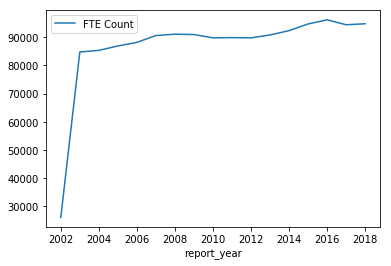

In [53]:
%matplotlib inline 
statewide_staffing.groupby("report_year").agg({"FTE Count":'sum'}).plot()

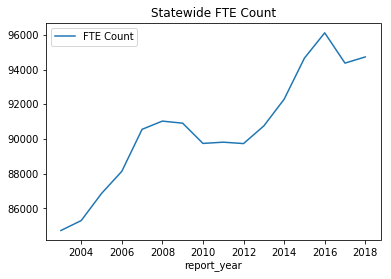

In [54]:
# Drop 2002
statewide_staffing = statewide_staffing[statewide_staffing["report_year"] > 2002]
statewide_staffing.groupby("report_year").agg({"FTE Count":'sum'}).plot(title="Statewide FTE Count")

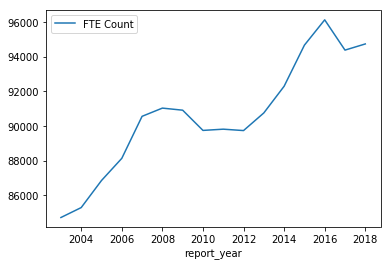

In [55]:
statewide_staffing.groupby(["report_year"]).agg({"FTE Count":'sum'}).plot()

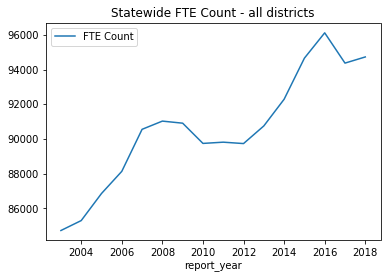

In [56]:
import matplotlib.pyplot as plt

statewide_staffing.groupby("report_year").agg({"FTE Count":'sum'}).plot(title="Statewide FTE Count - all districts")
plt.gcf().savefig("figures/for-story/3.1 ALT - statewide-fte-count ALL SCHOOLS.png")

In [57]:
statewide_staffing.groupby("report_year").agg({"FTE Count":'sum'}).to_csv("output/STATEWIDE_STAFFING.csv")

In [58]:
statewide_staffing["Assignment Category"].value_counts()

Library/Media - Support Staff                                                   16
Library/Media - Specialists (Certified)                                         16
Counselors  Social Workers  and School Psychologists                            16
Instructional Specialists Who Support Teachers                                  16
General Education - Paraprofessional Instructional Assistants                   16
Administrators  Coordinators and Department Chairs - School Level               16
General Education - Teachers and Instructors                                    16
Other Staff Providing Non-Instructional Services/Support                        16
Special Education - Teachers and Instructors                                    16
School Nurses                                                                   16
Special Education - Paraprofessional Instructional Assistants                   16
Administrators  Coordinators and Department Chairs - District Central Office    16
Name

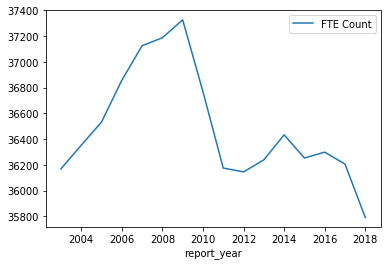

In [59]:
statewide_staffing[statewide_staffing["Assignment Category"] == "General Education - Teachers and Instructors"].groupby("report_year").agg({"FTE Count":'sum'}).plot()

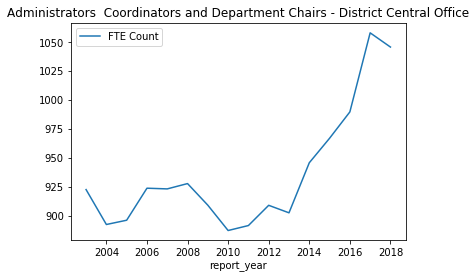

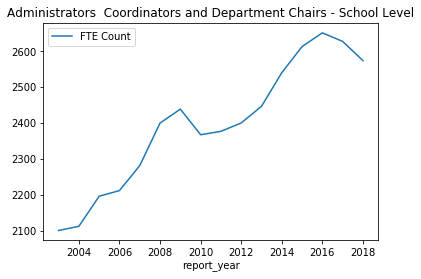

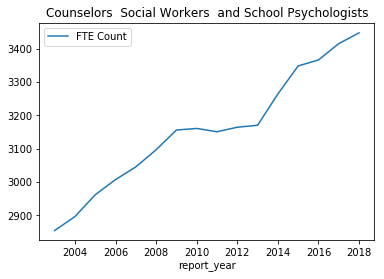

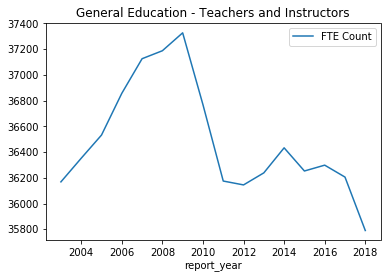

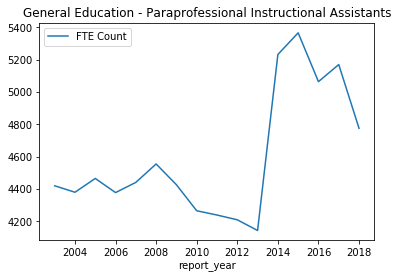

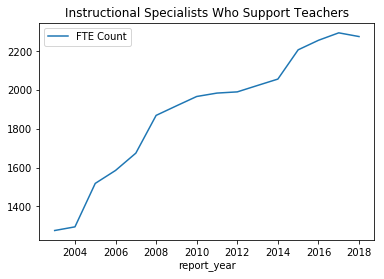

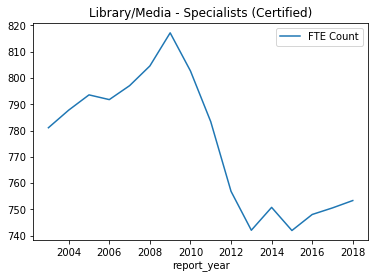

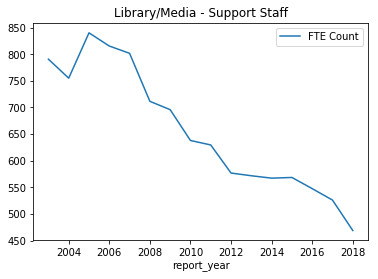

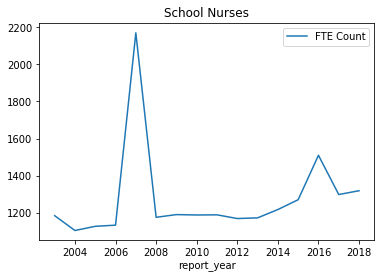

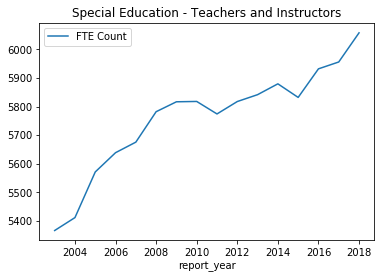

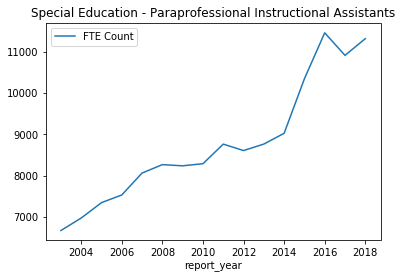

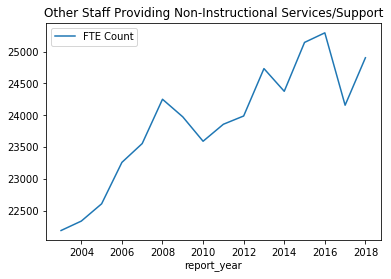

In [60]:
for cat in statewide_staffing["Assignment Category"].unique():
    tmpdf = statewide_staffing[statewide_staffing["Assignment Category"] == cat].groupby("report_year").agg({"FTE Count":'sum'})
    tmpdf.to_csv("output/STATEWIDE_STAFFING-%s.csv" % cat.replace("/","-"))
    tmpdf.plot(title=cat)
    plt.savefig("figures/for-story/MISC-FTE %s.png" % cat.replace("/","-"))

# Looking for districts with big drops

In [61]:
#staffing_df_copy.reset_index().set_index(["City","report_year"])
staffing_df["FTE CHANGE"] = staffing_df.groupby(level=0)["FTE Count"].diff()
staffing_df.sort_values(by="FTE CHANGE")

/Users/jakekara/pandas/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


FTE Count EDSIGHT_ENROLLMENT  Teacher FTE Count  \
City          report_year                                                    
NORWALK       2017            1361.2              11498              624.1   
              2010             956.0              10962              711.8   
              2012             988.8              11183              740.1   
NEW HAVEN     2016            3235.2              21725             1405.1   
HARTFORD      2008            3277.7              22679             1436.1   
              2017            3254.4              20891             1222.5   
BRANFORD      2016             296.7               3066              225.5   
NAUGATUCK     2017             573.9               4281              249.9   
EASTON        2009             394.0               1304              160.1   
RIDGEFIELD    2018             805.2               4929              338.9   
WALLINGFORD   2013            1033.5               6292              424.0   
NEW HAVEN     2015            3781.4              21711             1381.1   
WESTPORT      2016             984.3               5714              436.6   
WATERBURY     2011            2575.2              18188             1102.4   
              2016            2753.5              18862             1162.9   
NEW LONDON    2017             313.4               3559              208.7   
CHESHIRE      2009             737.4               5032              299.0   
BRIDGEPORT    2017            2989.9              21222             1210.7   
HARTFORD      2010            3174.0              21552             1297.6   
NEW HAVEN     2007            3150.8                NaN             1258.5   
WESTON        2006             245.8                NaN              179.0   
EASTON        2013             368.7               1133              146.8   
NEW BRITAIN   2014            1237.6              10136              564.1   
SHELTON       2011             672.4               5305              290.5   
RIDGEFIELD    2015             661.9               5178              342.3   
STAMFORD      2013            2091.2              15834             1047.4   
WETHERSFIELD  2015             508.3               3647              236.0   
ENFIELD       2011             811.8               5912              392.9   
SOMERS        2010             145.3               1660              102.8   
HARTFORD      2018            3141.5              20142             1164.8   
...                              ...                ...                ...   
STONINGTON    2005             406.8                NaN              157.3   
STRATFORD     2005             986.4                NaN              448.3   
SUFFIELD      2005             330.1                NaN              152.0   
THOMASTON     2005             191.8                NaN               79.0   
THOMPSON      2005             211.7                NaN               90.7   
TOLLAND       2005             454.2                NaN              190.5   
TORRINGTON    2005             691.5                NaN              287.3   
TRUMBULL      2005             895.9                NaN              390.0   
UNION         2005              10.8                NaN                5.0   
VERNON        2005             623.3                NaN              257.9   
VOLUNTOWN     2005              76.1                NaN               23.5   
WALLINGFORD   2005            1084.5                NaN              460.7   
WATERBURY     2005            2691.2                NaN             1141.9   
WATERFORD     2005             515.9                NaN              202.5   
WATERTOWN     2005             478.9                NaN              193.6   
WEST HARTFORD 2005            1438.0                NaN              639.4   
WEST HAVEN    2005            1013.0                NaN              438.2   
WESTBROOK     2005             169.3                NaN               79.6   
WESTON        2005             400.3             